# Nonlinear bias using generalized tracers and power spectra
This example showcases how to do nonlinear biasing with the generalized tracers and 2D power spectra implemented in CCL.

For more on generalized tracers and power spectra, see GeneralizedTracers.ipynb

In [17]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
%matplotlib inline

Note that the perturbation theory functionality lives within `pyccl.nl_pt`.

## Preliminaries
Let's just begin by setting up a cosmology and some biases

In [18]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Biases for number counts 
b_1 = 2.0 # constant values for now
b_2 = 1.0
b_s = 1.0

# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

# Define a redshift range and associated growth factor:
#z = np.linspace(0,1,128)
z = np.linspace(0,8,1024)
#z = np.linspace(0, 1.5, 1024)
gz = ccl.growth_factor(cosmo, 1./(1+z))

# Let's convert the a_IA values into the correctly normalized c_IA values:
# First, do it explicitly:
Om_m = cosmo['Omega_m']
rho_crit = lib.cvar.constants.RHO_CRITICAL
rho_m = lib.cvar.constants.RHO_CRITICAL * cosmo['Omega_m']
Om_m_fid = 0.3 #or could use DES convention and just remove Om_m/Om_m_fid

c_1_t = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gz
c_d_t = -1*a_d*5e-14*rho_crit*cosmo['Omega_m']/gz
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']**2/(Om_m_fid*gz**2) #Blazek2019 convention
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']/(gz**2) #DES convention

# Or we just use the built-in function for IA normalization:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1, a1delta=a_d, a2=a_2, Om_m2_for_c2 = False)

## PT tracers
Power spectra are Fourier-space correlations between two quantities. In CCL the quantities you want to correlate are defined in terms of so-called `PTTracers`. Here we create three of them, one for number counts (galaxy clustering), one for intrinsic alignments, and one for matter.

In [19]:
# Number counts (galaxy clustering)
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)

# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d))
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()

# Note that we've assumed constant biases for simplicity, but you can also make them z-dependent:
bz = b_1 / gz
ptt_g_b = pt.PTNumberCountsTracer(b1=(z, bz))


## PT calculator
Another object, `PTCalculator` takes care of initializing FastPT (essentially precomputing some of the stuff it needs to get you PT power spectra). You'll need one of these before you can compute P(k)s.

In [20]:
# The `with_NC` and `with_IA` flags will tell FastPT to initialize the right things.
# `log10k_min/max and nk_per_decade will define the sampling in k you should use.
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

## PT power spectra
Let's compute some power spectra! We do so by calling `get_pt_pk2d` with whatever tracers you want to cross-correlate. This will return a `Pk2D` object that you can then evaluate at whatever scale and redshift you want.

In [21]:
# Galaxies x galaxies.
# If `tracer2` is missing, an auto-correlation for the first tracer is assumed.
pk_gg = pt.get_pt_pk2d(cosmo, ptt_g, ptc=ptc)

# Galaxies x matter
pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

# Galaxies x IAs
pk_gi = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i, ptc=ptc)

# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)


**Note:** FastPT is not yet able to compute IAs x galaxies in a consistent way. What CCL does is to use the full non-linear model for IAs, but use a linear bias for galaxies.

OK, let's now plot a few of these!

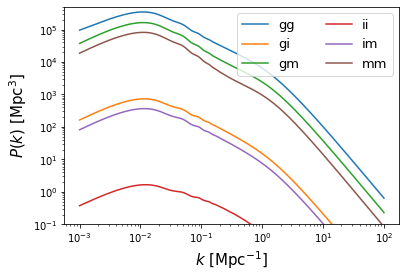

In [22]:
# Let's plot everything at z=0

ks = np.logspace(-3,2,512)
ps = {}
ps['gg'] = pk_gg.eval(ks, 1., cosmo)
ps['gi'] = pk_gi.eval(ks, 1., cosmo)
ps['gm'] = pk_gm.eval(ks, 1., cosmo)
ps['ii'] = pk_ii.eval(ks, 1., cosmo)
ps['im'] = pk_im.eval(ks, 1., cosmo)
ps['mm'] = pk_mm.eval(ks, 1., cosmo)

plt.figure()
for pn, p in ps.items():
    plt.plot(ks, abs(p), label=pn)
plt.loglog()
plt.legend(loc='upper right', ncol=2, fontsize=13)
plt.ylim([1E-1, 5E5])
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

We can also compute the B-mode power spectrum for intrinsic alignments:

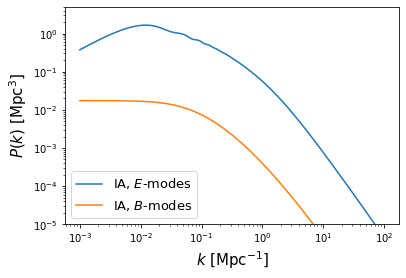

In [23]:
# pk_ii_bb was already output above, but we could also get it alone this way:
# pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, ptc=ptc, return_ia_bb=True)

plt.figure()
plt.plot(ks, pk_ii.eval(ks, 1., cosmo), label='IA, $E$-modes')
plt.plot(ks, pk_ii_bb.eval(ks, 1., cosmo), label='IA, $B$-modes')
plt.loglog()
plt.legend(loc='lower left', fontsize=13)
plt.ylim([1E-5, 5E0])
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

## Angular power spectra
We can now use these P(k)s to compute angular power spectra, passing them to `ccl.angular_cl`.
Let's illustrate this specifically for the usual 3x2pt. We will define three standard tracers (not `PTTracer`s, but the ones used to compute angular power spectra), one for number counts, one for weak lensing shear, and one for intrinsic alignments, which is also a WeakLensingTracer. The first one will be associated with `PTNumberCountsTracer`, the second with `PTMatterTracer`, and the third with `PTIntrinsicAlignmentTracer`.

In [24]:
z = np.linspace(0, 1.5, 1024)
# nz = np.exp(-((z-0.7)/0.1)**2) # original
# nz = np.exp(-((z-0.7)/1.0)**2) #wider distribution, for testing
nz = np.exp(-((z-0.0)/0.1)**2) # change end points, for testing

# Number counts
# We give this a bias of 1, since we've taken care of galaxy bias at the P(k) level.
t_g = ccl.NumberCountsTracer(cosmo, False, dndz=(z, nz), bias=(z, np.ones_like(z)))

# Lensing
t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nz))

# Intrinsic alignments
# Note the required settings to isolate the IA term and set the IA bias to 1,
# since we have added the IA bias terms at the P(k) level.
t_i = ccl.WeakLensingTracer(cosmo, dndz=(z, nz), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z, nz), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=True)


In [25]:
## For testing, let's also try directly making NLA with P_NL, without going through the nl_pt:
gzz = ccl.growth_factor(cosmo, 1./(1+z))
c_1_t = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gzz
t_i_nla_alt = ccl.WeakLensingTracer(cosmo, dndz=(z, nz), has_shear=False, ia_bias=(z,c_1_t) , use_A_ia=False)
sf = (1./(1+z))[::-1]
log10k_min=-4
log10k_max=2
nk_per_decade=20
nk_total = int((log10k_max - log10k_min) * nk_per_decade)
ks = np.logspace(log10k_min, log10k_max, nk_total)
lpk_array = np.log(np.array([ccl.nonlin_matter_power(cosmo,ks,a) for a in sf]))

# Create a Pk2D object
pk_nl = ccl.Pk2D(a_arr=sf, lk_arr=np.log(ks), pk_arr=lpk_array, is_logp=True)

Testing for the extrapolation in k (and z?)

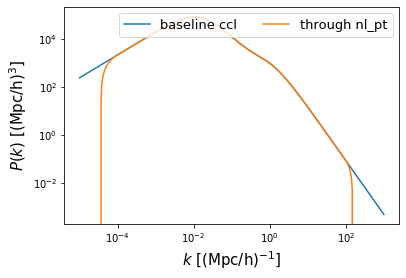

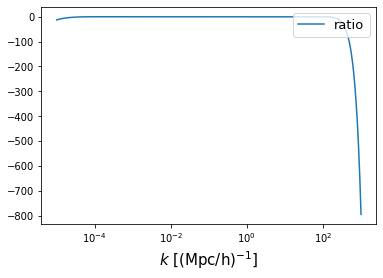

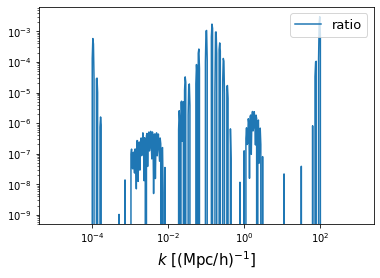

In [31]:
zz=0
nk = 512
log10kmin = -5
log10kmax = 3
k = np.logspace(log10kmin,log10kmax,nk)
pk_nl0 = pk_nl.eval(k,1./(1+zz),cosmo)
pk_nl0_pt = pk_mm.eval(k,1./(1+zz),cosmo)

plt.loglog()
plt.plot(k,pk_nl0,label='baseline ccl')
plt.plot(k,pk_nl0_pt,label='through nl_pt')
plt.legend(loc='upper right', ncol=2, fontsize=13)
plt.xlabel(r'$k\,\,[{\rm (Mpc/h)}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm (Mpc/h)^{3}}]$', fontsize=15)
plt.show()

plt.semilogx()
plt.plot(k,pk_nl0_pt/pk_nl0-1,label='ratio')
plt.legend(loc='upper right', ncol=2, fontsize=13)
plt.xlabel(r'$k\,\,[{\rm (Mpc/h)}^{-1}]$', fontsize=15)

plt.show()

plt.loglog()
plt.plot(k,pk_nl0_pt/pk_nl0-1,label='ratio')
plt.legend(loc='upper right', ncol=2, fontsize=13)
plt.xlabel(r'$k\,\,[{\rm (Mpc/h)}^{-1}]$', fontsize=15)
plt.show()


Now compute angular power spectra. Note how we pass the P(k)s we just calculated as `p_of_k_a`.

In [15]:
ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
cls={}
cls['gg'] = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)
cls['gG'] = ccl.angular_cl(cosmo, t_g, t_l, ell, p_of_k_a=pk_gm)
cls['GG'] = ccl.angular_cl(cosmo, t_l, t_l, ell, p_of_k_a=pk_mm)
cls['GI'] = ccl.angular_cl(cosmo, t_l, t_i, ell, p_of_k_a=pk_im)
cls['IG'] = ccl.angular_cl(cosmo, t_i, t_l, ell, p_of_k_a=pk_im)
cls['GI,NLA'] = ccl.angular_cl(cosmo, t_l, t_i_nla, ell)
cls['II'] = ccl.angular_cl(cosmo, t_i, t_i, ell, p_of_k_a=pk_ii)
cls['II,NLA'] = ccl.angular_cl(cosmo, t_i, t_i, ell, p_of_k_a=pk_ii_nla)
cls['II,NLA orig'] = ccl.angular_cl(cosmo, t_i_nla, t_i_nla, ell)
cls['II,NLA alt'] = ccl.angular_cl(cosmo, t_i_nla_alt, t_i_nla_alt, ell, p_of_k_a=pk_nl)
#cls['II,NLA alt'] = ccl.angular_cl(cosmo, t_i_nla_alt, t_i_nla_alt, ell)

Plot away!

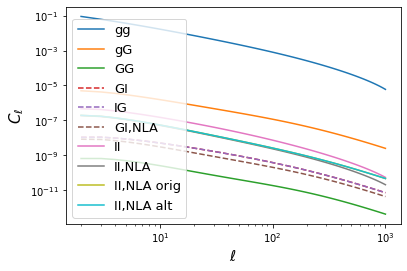

[0.96707026 0.96544245 0.96383803 0.9622912  0.96080751 0.95938682
 0.95802692 0.95672254 0.95546893 0.95426372 0.95310105 0.95197809
 0.95088836 0.94983742 0.94881012 0.94781669 0.94591224 0.94499731
 0.94410561 0.94238829 0.94156095 0.93995927 0.93918453 0.93768277
 0.9362368  0.93484011 0.93348795 0.93153238 0.93027559 0.92844635
 0.92667982 0.9249668  0.92330107 0.92167665 0.91956813 0.91751608
 0.91551217 0.9135495  0.91114373 0.90878855 0.90658686 0.90373118
 0.90103062 0.8984042  0.89527845 0.8922231  0.88918099 0.88531694
 0.88186134 0.87758347 0.87373622 0.86902493 0.86431193 0.85915687
 0.85354903 0.84791399 0.84137239 0.83478572 0.82770783 0.82011586
 0.81155207 0.80244344 0.79323297 0.78251919 0.77119723 0.75925138
 0.7461765  0.73243253 0.71699619 0.70082886 0.68288055 0.66361131
 0.64298441 0.62041975 0.59640136 0.57033272 0.54158277 0.51063428
 0.47742288 0.44129014]
[1.00000968 1.00001159 1.0000112  1.0000141  1.00001276 1.00001234
 1.00001258 1.00001113 1.00000966 1.00

In [16]:
plt.figure()
for cn, c in cls.items():
    if c[0]>0:
        plt.plot(ell, c, label=cn)
    else:
        plt.plot(ell, abs(c), '--', label=cn)
plt.loglog()
plt.legend(loc='lower left', ncol=1, fontsize=13)
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.show()
print(cls['II,NLA']/cls['II,NLA orig'])
print(cls['II,NLA alt']/cls['II,NLA orig'])

Or if you want an angular correlation function:

In [13]:
theta_deg = np.logspace(-1, np.log10(5.), 20) # Theta is in degrees

#Cosmic shear:
xi_plus_IA = ccl.correlation(cosmo, ell, cls['II']+ cls['GI']+cls['IG'],
                          theta_deg, type='GG+', method='FFTLog')
xi_minus_IA = ccl.correlation(cosmo, ell, cls['II']+ cls['GI']+cls['IG'],
                           theta_deg, type='GG-', method='FFTLog')

xi_plus = ccl.correlation(cosmo, ell, cls['GG'],
                          theta_deg, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(cosmo, ell, cls['GG'],
                           theta_deg, type='GG-', method='FFTLog')


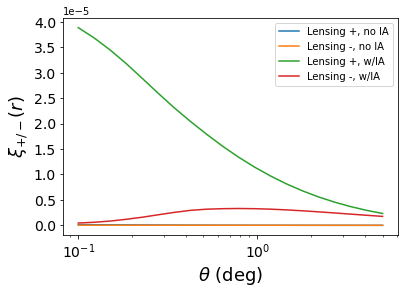

In [14]:
# Plot
plt.plot(theta_deg, xi_plus, label='Lensing +, no IA')
plt.plot(theta_deg, xi_minus, label='Lensing -, no IA')
plt.plot(theta_deg, xi_plus+xi_plus_IA, label='Lensing +, w/IA')
plt.plot(theta_deg, xi_minus+xi_minus_IA, label='Lensing -, w/IA')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$\xi_{+/-} (r)$',fontsize=18)
plt.show()